# imports

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import emoji
import contractions
import nltk
import os
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nlpaug.augmenter.word as naw
import seaborn as sns
import math
from collections import Counter

# Download necessary NLTK resources once at the beginning
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# Load Data

In [ ]:
# I used chatgpt to add vocabulary, did not use an API I just incremented the val_chatgp data manually
# prompt- you are a linguistic and you are labeling reality tv sentences in this case you are focus on dating show similar to the island of temptations
# they should add to the vocab and avoid contractions

In [10]:
def load_and_preprocess_data():
    """Load, combine, and preprocess the datasets"""
    # Load datasets
    df1 = pd.read_csv('/content/test.txt', header=None, sep=';')
    df2 = pd.read_csv('/content/train.txt', header=None, sep=';')
    df3 = pd.read_csv('/content/val_chatgpt.txt', header=None, sep=';')
    df4 = pd.read_excel('/content/FINAL_DATASET.xlsx')

    # Rename columns
    df1.columns = ['text', 'main_category']
    df2.columns = ['text', 'main_category']
    df3.columns = ['text', 'main_category']
    df4 = df4[['Translation', 'Corrected_Emotion']]
    df4.rename(columns={'Translation': 'text', 'Corrected_Emotion': 'main_category'}, inplace=True)

    # Combine datasets
    df = pd.concat([df1, df2, df3, df4], ignore_index=True)
    print("Initial shape:", df.shape)

    # Standardize emotion categories
    df['main_category'] = df['main_category'].replace({'joy': 'happiness', 'love': 'happiness'})

    # Remove duplicates and NaN values
    df.drop_duplicates(subset=['text'], inplace=True)
    print("Shape after removing duplicates:", df.shape)

    df.dropna(inplace=True)
    print("Shape after removing NaNs:", df.shape)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    return df

# Call the function to create the df variable
df = load_and_preprocess_data()
df.head(3)

Initial shape: (26201, 2)
Shape after removing duplicates: (25491, 2)
Shape after removing NaNs: (24876, 2)


,text,main_category
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness


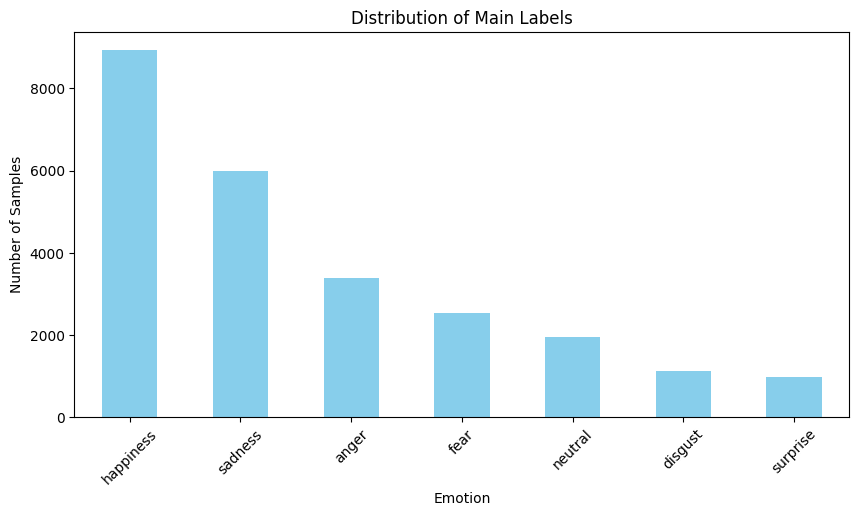

In [11]:
label_counts = df['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# Prepare Data

In [ ]:
# For improving sentence structure without filtering:

def improve_sentence_structure(text):
    # Check if the text lacks a subject or verb
    words = text.split()
    if len(words) >= 2:
        # Simple heuristic: Add a pronoun if the text starts with a verb
        pos_tags = nltk.pos_tag(words)
        if pos_tags[0][1].startswith('VB') and not any(w.lower() in ['i', 'you', 'he', 'she', 'they', 'we'] for w in words[:2]):
            text = "I " + text

    # Ensure proper ending punctuation
    if text and not text[-1] in ['.', '!', '?']:
        text = text + '.'

    return text

In [ ]:
def replace_emojis(text):
    """Convert emojis to their textual descriptions (without colons)."""
    demojized = emoji.demojize(text, delimiters=(" ", " "))
    return demojized.replace(":", "").replace("_", " ")

def clean_text(text):
    """Clean text by removing unwanted characters, links, etc."""
    stop_words = set(stopwords.words('english'))

    # Text cleaning pipeline
    text = replace_emojis(text)                           # Convert emojis to text
    text = text.lower()                                   # Convert to lowercase

    # More comprehensive URL and HTML removal
    text = re.sub(r'(https?:\/\/)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # Remove links
    text = re.sub(r"href\s*=\s*['\"](.*?)['\"]", "", text) # Remove href attributes
    text = re.sub(r"src\s*=\s*['\"](.*?)['\"]", "", text)  # Remove src attributes

    # Additional cleaning for href/http fragments
    text = re.sub(r'\b(href|http|www|html|com)\b', '', text)  # Remove common web-related words

    # Transform hashtags and mentions instead of removing
    text = re.sub(r'#(\w+)', r'hashtag \1', text)        # transform hashtags
    text = re.sub(r'@(\w+)', r'user \1', text)           # transform mentions

    # General text cleaning
    text = re.sub(r"[^a-zA-Z0-9'\[\].,!?]", " ", text)    # Keep only text/punctuation
    text = re.sub(r'\d+', '', text)                       # Remove numbers
    text = re.sub(r'\[[^\]]*\]', '', text)                # Remove brackets
    text = re.sub(r'(?<=\S)[.,](?=\S)', '', text)         # Fix punctuation
    text = re.sub(r'([.!?])\1+', r'\1', text)             # Reduce repeated punctuation

    # Remove contractions if desired
    text = contractions.fix(text)                         # Expand contractions

    # Remove stopwords
    words = text.split()
    text = " ".join([word for word in words if word not in stop_words])

    # Remove extra spaces (after all other processing)
    text = " ".join(text.split())

    return text

def apply_text_cleaning(df):
    """Apply text cleaning to the dataframe"""
    # Apply cleaning
    df['text'] = df['text'].astype(str).apply(clean_text)

    # Remove empty texts
    df = df[df['text'].str.strip() != '']
    print("Dataset shape after cleaning:", df.shape)

    return df

# call the function to clean the text
df = apply_text_cleaning(df)

Dataset shape after cleaning: (24874, 2)


In [ ]:
# print the cleaned text
df

,text,main_category
0,feeling rather rotten ambitious right,sadness
1,updating blog feel shitty,sadness
2,never make separate ever want feel like ashamed,sadness
3,left bouquet red yellow tulips arm feeling sli...,happiness
4,feeling little vain one,sadness
...,...,...
24871,climb it.,neutral
24872,"it, maneuver way.",neutral
24873,teammates ropes.,neutral
24874,determine pace.,neutral



=== ANALYZING TEXT LENGTHS ===

Text length statistics (in characters):
count    24874.000000
mean        54.920640
std         34.769904
min          1.000000
25%         29.000000
50%         47.000000
75%         73.000000
max        232.000000
Name: text_length_chars, dtype: float64

Text length statistics (in words):
count    24874.000000
mean         8.128488
std          5.029481
min          1.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         35.000000
Name: text_length_words, dtype: float64


<ipython-input-15-289159fc75c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length_chars'] = df[text_col].apply(len)
<ipython-input-15-289159fc75c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length_words'] = df[text_col].apply(lambda x: len(x.split()))


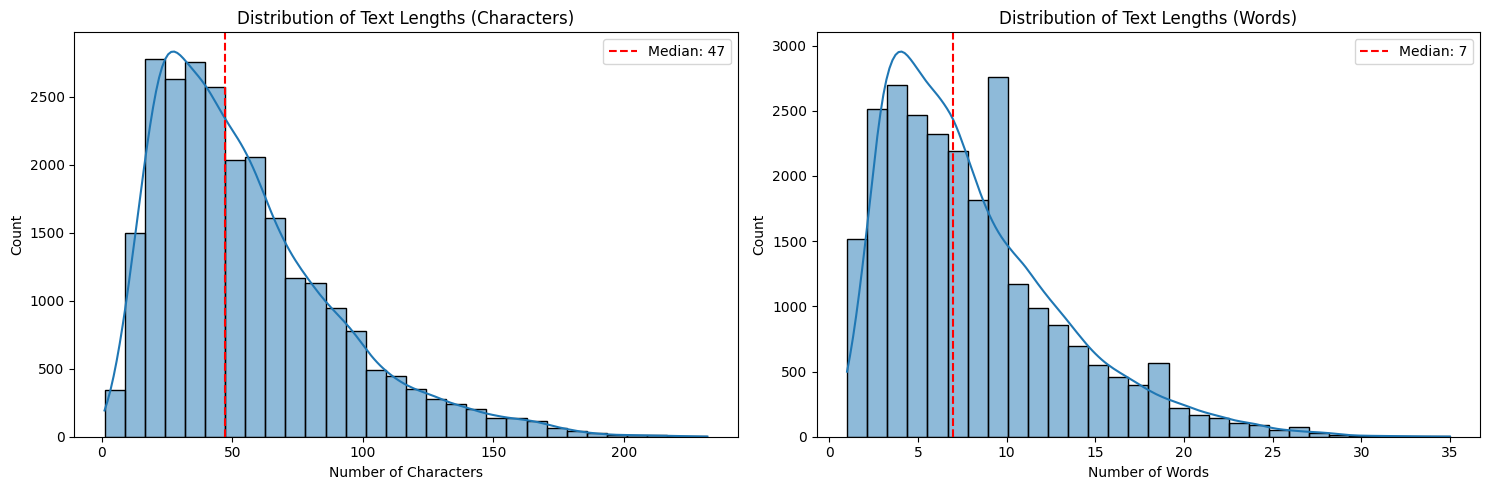


Average text length by category:
               text_length_chars  text_length_words
main_category                                      
happiness              59.216125           8.902240
fear                   58.084356           8.575842
sadness                56.844225           8.548721
anger                  55.568222           8.146486
surprise               51.582564           7.738462
disgust                61.070222           6.945778
neutral                22.247692           3.562564


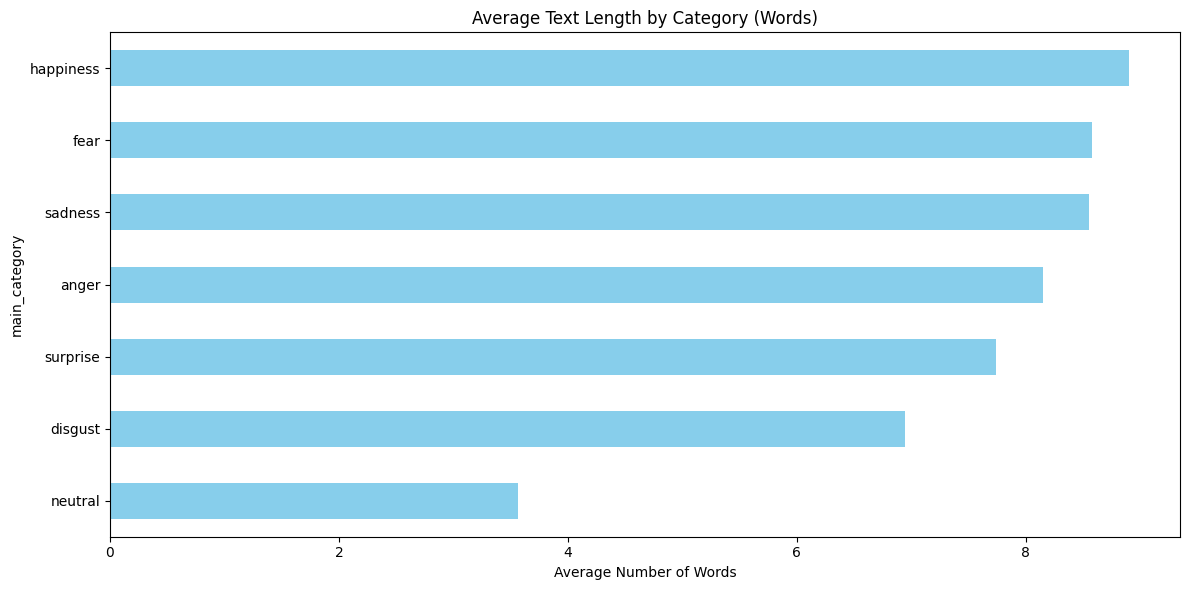

In [15]:
def analyze_text_lengths(df, text_col='text'):
    print("\n=== ANALYZING TEXT LENGTHS ===")

    df['text_length_chars'] = df[text_col].apply(len)
    df['text_length_words'] = df[text_col].apply(lambda x: len(x.split()))

    # Display statistics
    print("\nText length statistics (in characters):")
    print(df['text_length_chars'].describe())

    print("\nText length statistics (in words):")
    print(df['text_length_words'].describe())

    # Plot the distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Characters distribution
    sns.histplot(df['text_length_chars'], bins=30, kde=True, ax=ax1)
    ax1.set_title('Distribution of Text Lengths (Characters)')
    ax1.set_xlabel('Number of Characters')
    ax1.axvline(df['text_length_chars'].median(), color='red', linestyle='--',
                label=f'Median: {df["text_length_chars"].median():.0f}')
    ax1.legend()

    # Words distribution
    sns.histplot(df['text_length_words'], bins=30, kde=True, ax=ax2)
    ax2.set_title('Distribution of Text Lengths (Words)')
    ax2.set_xlabel('Number of Words')
    ax2.axvline(df['text_length_words'].median(), color='red', linestyle='--',
                label=f'Median: {df["text_length_words"].median():.0f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Show text length by category
    print("\nAverage text length by category:")
    category_stats = df.groupby('main_category')[['text_length_chars', 'text_length_words']].mean()
    print(category_stats.sort_values('text_length_words', ascending=False))

    # Plot average lengths by category
    plt.figure(figsize=(12, 6))
    category_stats['text_length_words'].sort_values().plot(kind='barh', color='skyblue')
    plt.title('Average Text Length by Category (Words)')
    plt.xlabel('Average Number of Words')
    plt.tight_layout()
    plt.show()
    return df

df = analyze_text_lengths(df)



=== ANALYZING TOP 10 WORDS BY CATEGORY ===


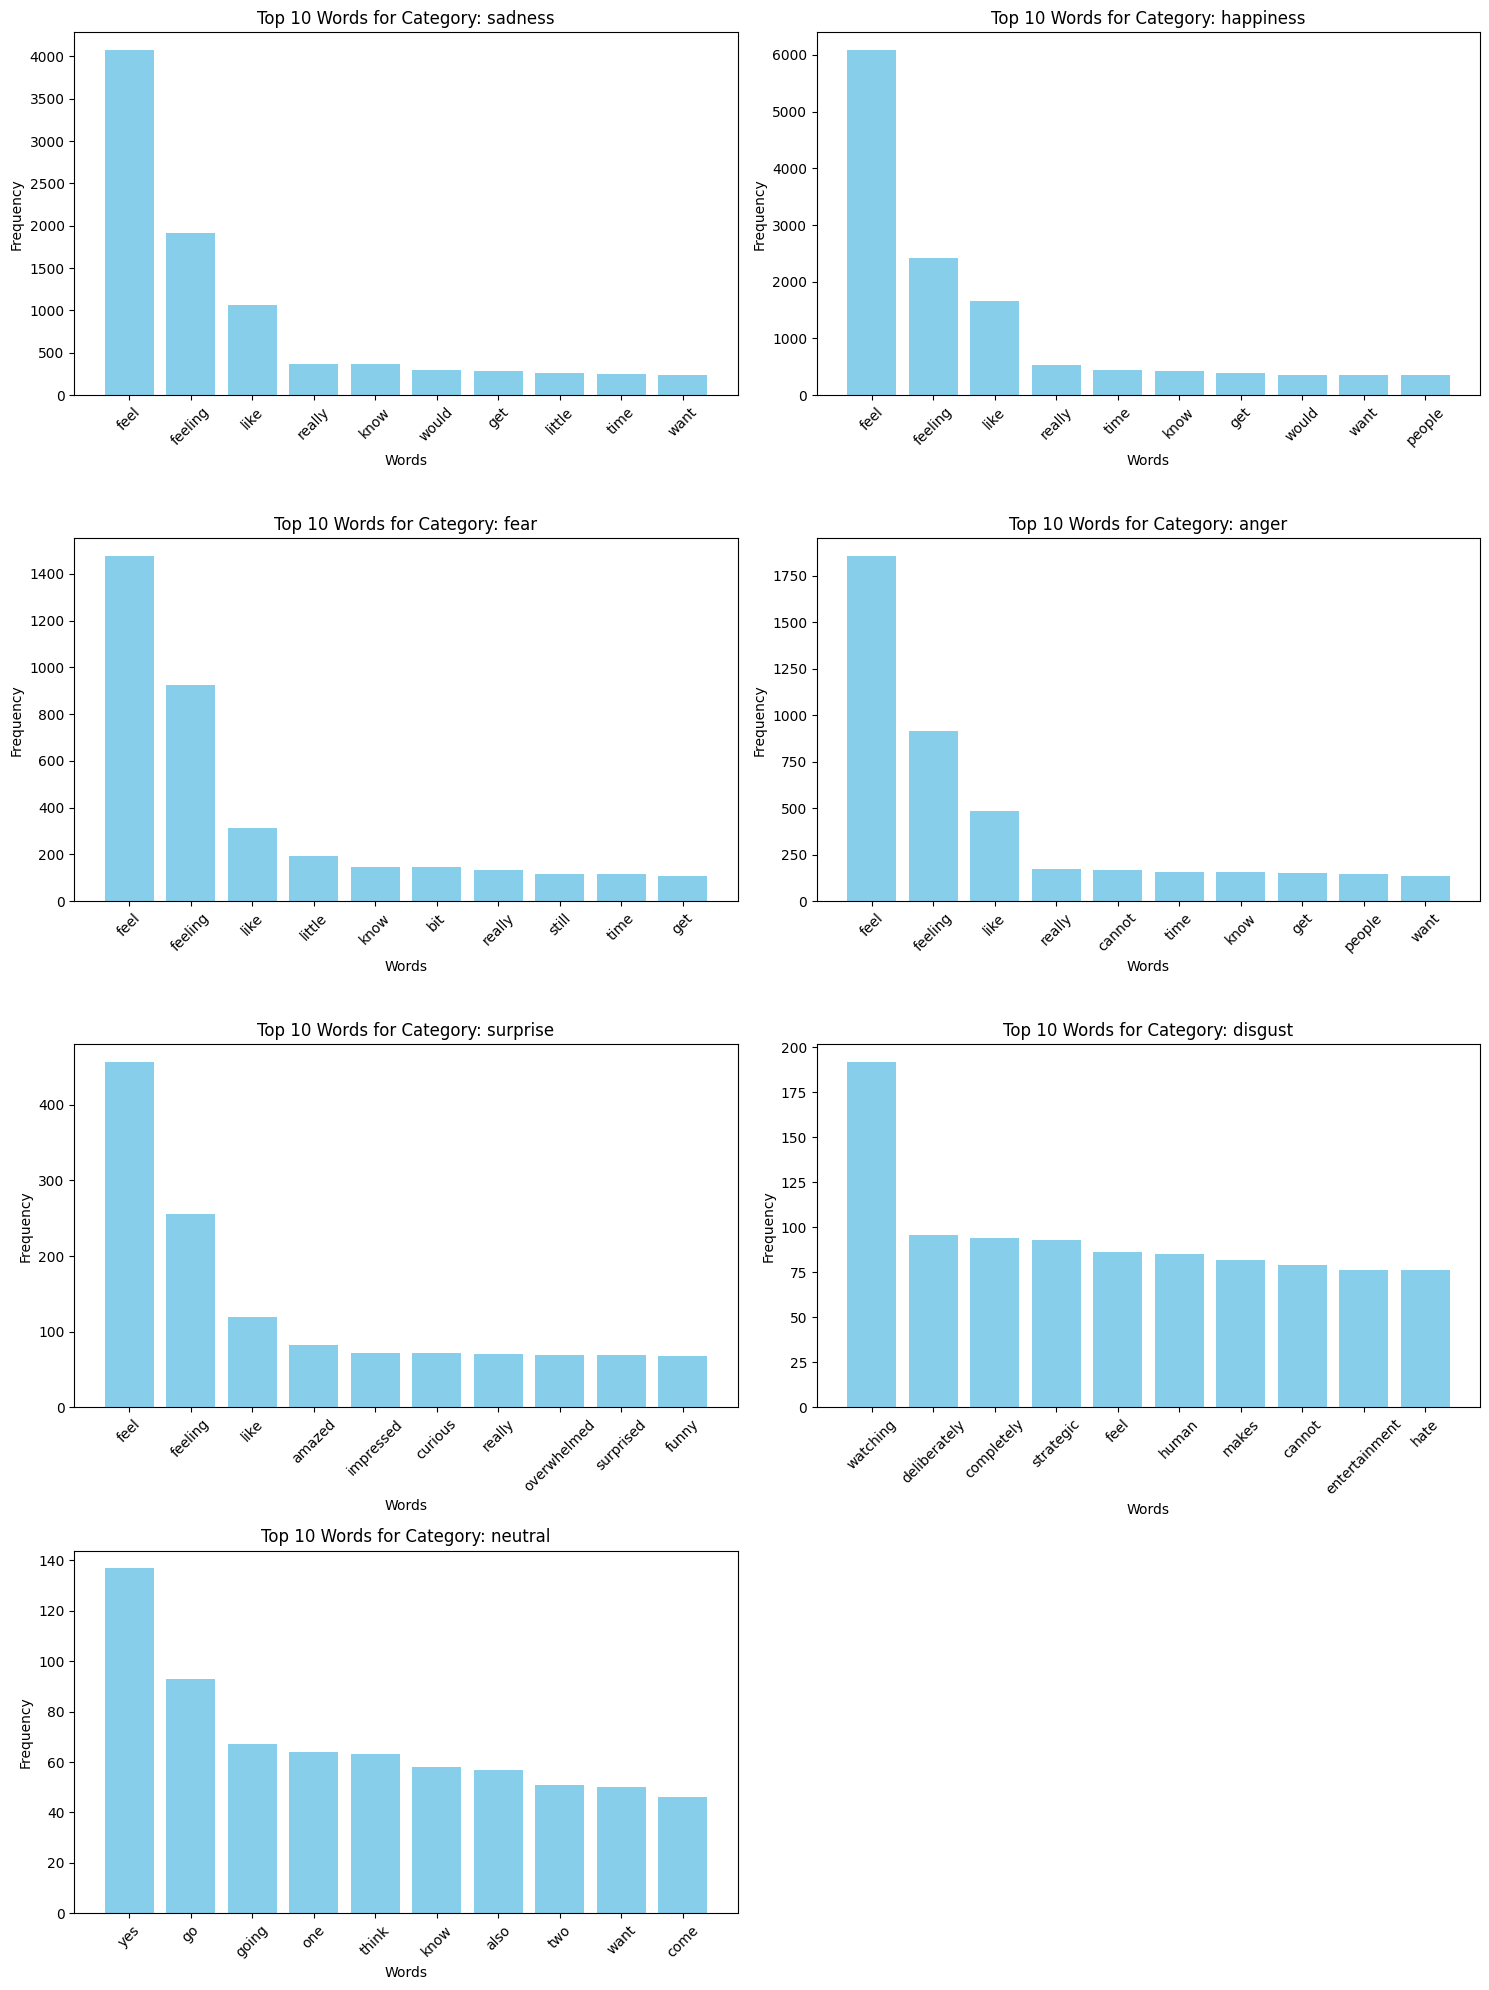


Most common words by category:

sadness:
  - feel: 4079
  - feeling: 1912
  - like: 1069
  - really: 370
  - know: 362
  - would: 296
  - get: 290
  - little: 259
  - time: 255
  - want: 240

happiness:
  - feel: 6094
  - feeling: 2422
  - like: 1658
  - really: 530
  - time: 445
  - know: 432
  - get: 388
  - would: 360
  - want: 357
  - people: 351

fear:
  - feel: 1478
  - feeling: 924
  - like: 315
  - little: 192
  - know: 147
  - bit: 146
  - really: 134
  - still: 116
  - time: 116
  - get: 108

anger:
  - feel: 1858
  - feeling: 917
  - like: 483
  - really: 172
  - cannot: 166
  - time: 158
  - know: 155
  - get: 152
  - people: 148
  - want: 138

surprise:
  - feel: 457
  - feeling: 256
  - like: 119
  - amazed: 83
  - impressed: 72
  - curious: 72
  - really: 70
  - overwhelmed: 69
  - surprised: 69
  - funny: 68

disgust:
  - watching: 192
  - deliberately: 96
  - completely: 94
  - strategic: 93
  - feel: 86
  - human: 85
  - makes: 82
  - cannot: 79
  - entertainment: 76

In [ ]:
def plot_top_words_by_category(df, text_col="text", label_col="main_category", top_n=10):
    """Plot the top words for each category"""
    print(f"\n=== ANALYZING TOP {top_n} WORDS BY CATEGORY ===")

    stop_words = set(stopwords.words('english'))
    unique_categories = df[label_col].unique()
    num_categories = len(unique_categories)

    # Create a grid for plotting
    ncols = 2
    nrows = math.ceil(num_categories / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
    axes = axes.flatten()

    # Store word frequencies by category for display
    category_word_counts = {}

    for i, category in enumerate(unique_categories):
        # Filter texts for the current category
        category_texts = df[df[label_col] == category][text_col]
        # Combine all texts into one string
        combined_text = " ".join(category_texts.tolist())
        # Tokenize: convert to lowercase and extract words
        words = re.findall(r'\w+', combined_text.lower())
        # Remove stopwords
        filtered_words = [word for word in words if word not in stop_words]
        # Count word frequencies
        word_counts = Counter(filtered_words)
        # Get the top N most common words
        top_words = word_counts.most_common(top_n)

        # Store for display
        category_word_counts[category] = top_words

        # If there are words, unzip the results
        if top_words:
            words_plot, counts_plot = zip(*top_words)
        else:
            words_plot, counts_plot = ([], [])

        ax = axes[i]
        ax.bar(words_plot, counts_plot, color='skyblue')
        ax.set_title(f"Top {top_n} Words for Category: {category}")
        ax.set_xlabel("Words")
        ax.set_ylabel("Frequency")
        ax.tick_params(axis='x', rotation=45)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Print the word frequencies for each category
    print("\nMost common words by category:")
    for category, words in category_word_counts.items():
        print(f"\n{category}:")
        for word, count in words:
            print(f"  - {word}: {count}")

    return category_word_counts

# Execute and show results
word_counts = plot_top_words_by_category(df)

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
nltk.download('punkt_tab')

# Define the synonym_mapping from your file
synonym_mapping = {
    "discovering": ["uncovering","discovering", "finding out", "exploring", "unveiling", "stumbling upon"],
    "realizing": ["comprehending", "realizing", "recognizing", "understanding", "perceiving", "acknowledging"],
    "finding": ["finding", "locating", "identifying", "detecting", "coming across", "spotting", "uncovering"],
    "learning": ["learning","acquiring knowledge", "studying", "grasping", "gaining insight", "comprehending"],
    "seeing": ["seeing","observing", "noticing", "perceiving", "beholding", "witnessing"],
    "the smell": ["the smell","the aroma", "the scent", "the odor", "the fragrance", "the essence", "the perfume"],
    "touching": ["touching","feeling", "contacting", "brushing", "handling", "making contact with"],
    "watching": ["watching","observing", "viewing", "monitoring", "gazing at", "looking at", "eyeing", "studying"],
    "hearing": ["hearing","listening to", "catching", "perceiving sound", "attending to", "overhearing"],
    "approaching": ["approaching","drawing near", "coming closer", "nearing", "advancing towards"],
    "entering": ["entering","going into", "penetrating", "accessing", "stepping into", "coming into"],
    "receiving": ["receiving","obtaining", "acquiring", "getting", "accepting", "taking in"],
    "thinking": ["thinking","pondering", "contemplating", "reflecting", "considering", "deliberating"],
    "wondering": ["wondering","questioning", "speculating", "curious about", "pondering", "contemplating"],
    "worrying": ["worrying","being concerned", "feeling anxious", "being troubled", "stressing"],
    "deliberately": ["deliberately","intentionally", "consciously", "knowingly", "calculatedly"],

}

# Words to drop
words_to_drop = ["http", "href," "www"]

# swap words
counters = {}

def determine_expected_pos(word):
    """Determine the expected part-of-speech tag for a word based on its typical usage."""
    # Dictionary mapping words to their expected POS tags
    # Use common NLTK POS tag prefixes: NN for nouns, VB for verbs, JJ for adjectives, etc.
    expected_pos_map = {
        "discovering": "VB",  # verb
        "realizing": "VB",    # verb
        "finding": "VB",      # verb
        "learning": "VB",     # verb
        "seeing": "VB",       # verb
        "the smell": "NN",    # noun
        "touching": "VB",     # verb
        "watching": "VB",     # verb
        "hearing": "VB",     # verb
        "approaching": "VB",  # verb
        "entering": "VB",     # verb
        "receiving": "VB",    # verb
        "thinking": "VB",     # verb
        "wondering": "VB",    # verb
        "worrying": "VB",     # verb
        "deliberately": "RB", # adverb
    }

    # Return the expected POS, or default to verb (VB) if not specified
    return expected_pos_map.get(word, "VB")

def context_aware_swap(text, mapping, counters, drop_words=None):
    """More context-aware word swapping"""
    if drop_words is None:
        drop_words = []

    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    new_tokens = []

    for i, (token, tag) in enumerate(pos_tags):
        token_lower = token.lower()

        # Skip dropped words
        if token_lower in drop_words:
            continue

        if token_lower in mapping:
            # Only replace if POS tag matches expected usage
            expected_pos = determine_expected_pos(token_lower)
            if tag.startswith(expected_pos):
                synonyms = mapping[token_lower]
                count = counters.get(token_lower, 0)
                replacement = synonyms[count % len(synonyms)]
                counters[token_lower] = count + 1
                new_tokens.append(replacement)
            else:
                new_tokens.append(token)
        else:
            new_tokens.append(token)

    return " ".join(new_tokens)

df['text_swapped_balanced'] = df['text'].apply(lambda x: context_aware_swap(x, synonym_mapping, counters))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


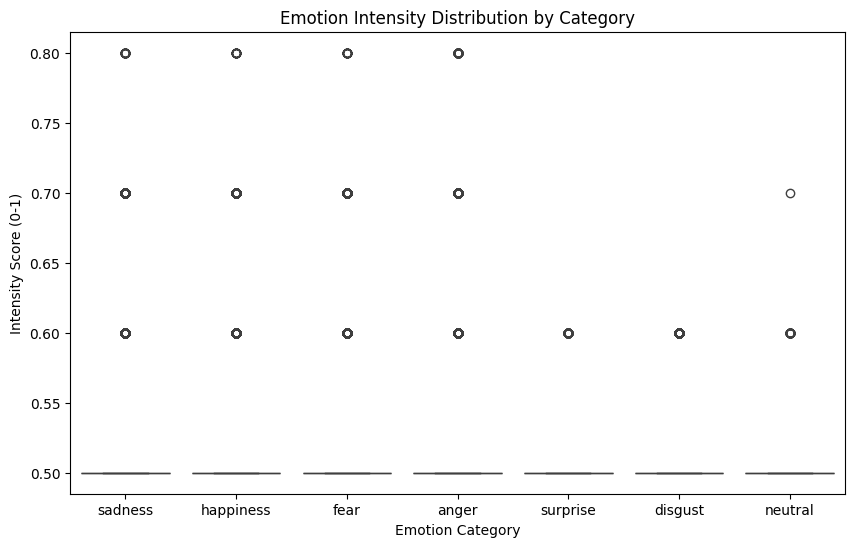

Average emotion intensity by category:
main_category
anger        0.526078
fear         0.521307
sadness      0.520391
disgust      0.518933
happiness    0.512923
surprise     0.510564
neutral      0.502718
Name: emotion_intensity, dtype: float64


In [18]:
# Create a simple rule-based intensity scorer
def estimate_emotion_intensity(text, emotion_category):
    """
    Estimate intensity of emotion in text on a scale of 0-1
    based on simple heuristics.
    """
    # Intensity markers (words that amplify emotions)
    intensifiers = {
        'very', 'extremely', 'incredibly', 'really', 'so', 'totally',
        'absolutely', 'completely', 'utterly', 'highly', 'deeply',
        'terribly', 'thoroughly', 'particularly', 'exceptionally'
    }

    # Words indicating stronger emotions by category
    strong_emotion_words = {
        'happiness': {'ecstatic', 'thrilled', 'overjoyed', 'delighted', 'elated', 'euphoric', 'blissful'},
        'sadness': {'devastated', 'heartbroken', 'miserable', 'depressed', 'grief', 'despair', 'anguish'},
        'anger': {'furious', 'outraged', 'livid', 'enraged', 'seething', 'irate', 'hate'},
        'fear': {'terrified', 'petrified', 'horrified', 'panicked', 'paranoid', 'dread', 'tormented'}
    }

    # Count features that indicate intensity
    words = text.lower().split()

    # Base score
    score = 0.5

    # Check for intensifier words
    if any(word in intensifiers for word in words):
        score += 0.1

    # Check for exclamation marks
    if '!' in text:
        score += 0.1 * text.count('!')  # Each ! adds 0.1 up to a cap

    # Check for strong emotion words for this category
    if emotion_category in strong_emotion_words:
        if any(word in strong_emotion_words[emotion_category] for word in words):
            score += 0.2

    # Check for ALL CAPS (shouting)
    if any(word.isupper() and len(word) > 2 for word in text.split()):
        score += 0.1

    # Check for repetition of letters (e.g., sooooo happy)
    if any(re.search(r'(\w)\1{2,}', word) for word in words):
        score += 0.1

    # Cap the maximum score at 1.0
    return min(score, 1.0)

# Apply to the dataset
df['emotion_intensity'] = df.apply(
    lambda row: estimate_emotion_intensity(row['text'], row['main_category']),
    axis=1
)

# Visualize intensity distribution by emotion
plt.figure(figsize=(10, 6))
sns.boxplot(x='main_category', y='emotion_intensity', data=df)
plt.title('Emotion Intensity Distribution by Category')
plt.xlabel('Emotion Category')
plt.ylabel('Intensity Score (0-1)')
plt.show()

# Show average intensity by emotion category
print("Average emotion intensity by category:")
print(df.groupby('main_category')['emotion_intensity'].mean().sort_values(ascending=False))


=== ANALYZING TOP 10 WORDS BY CATEGORY ===


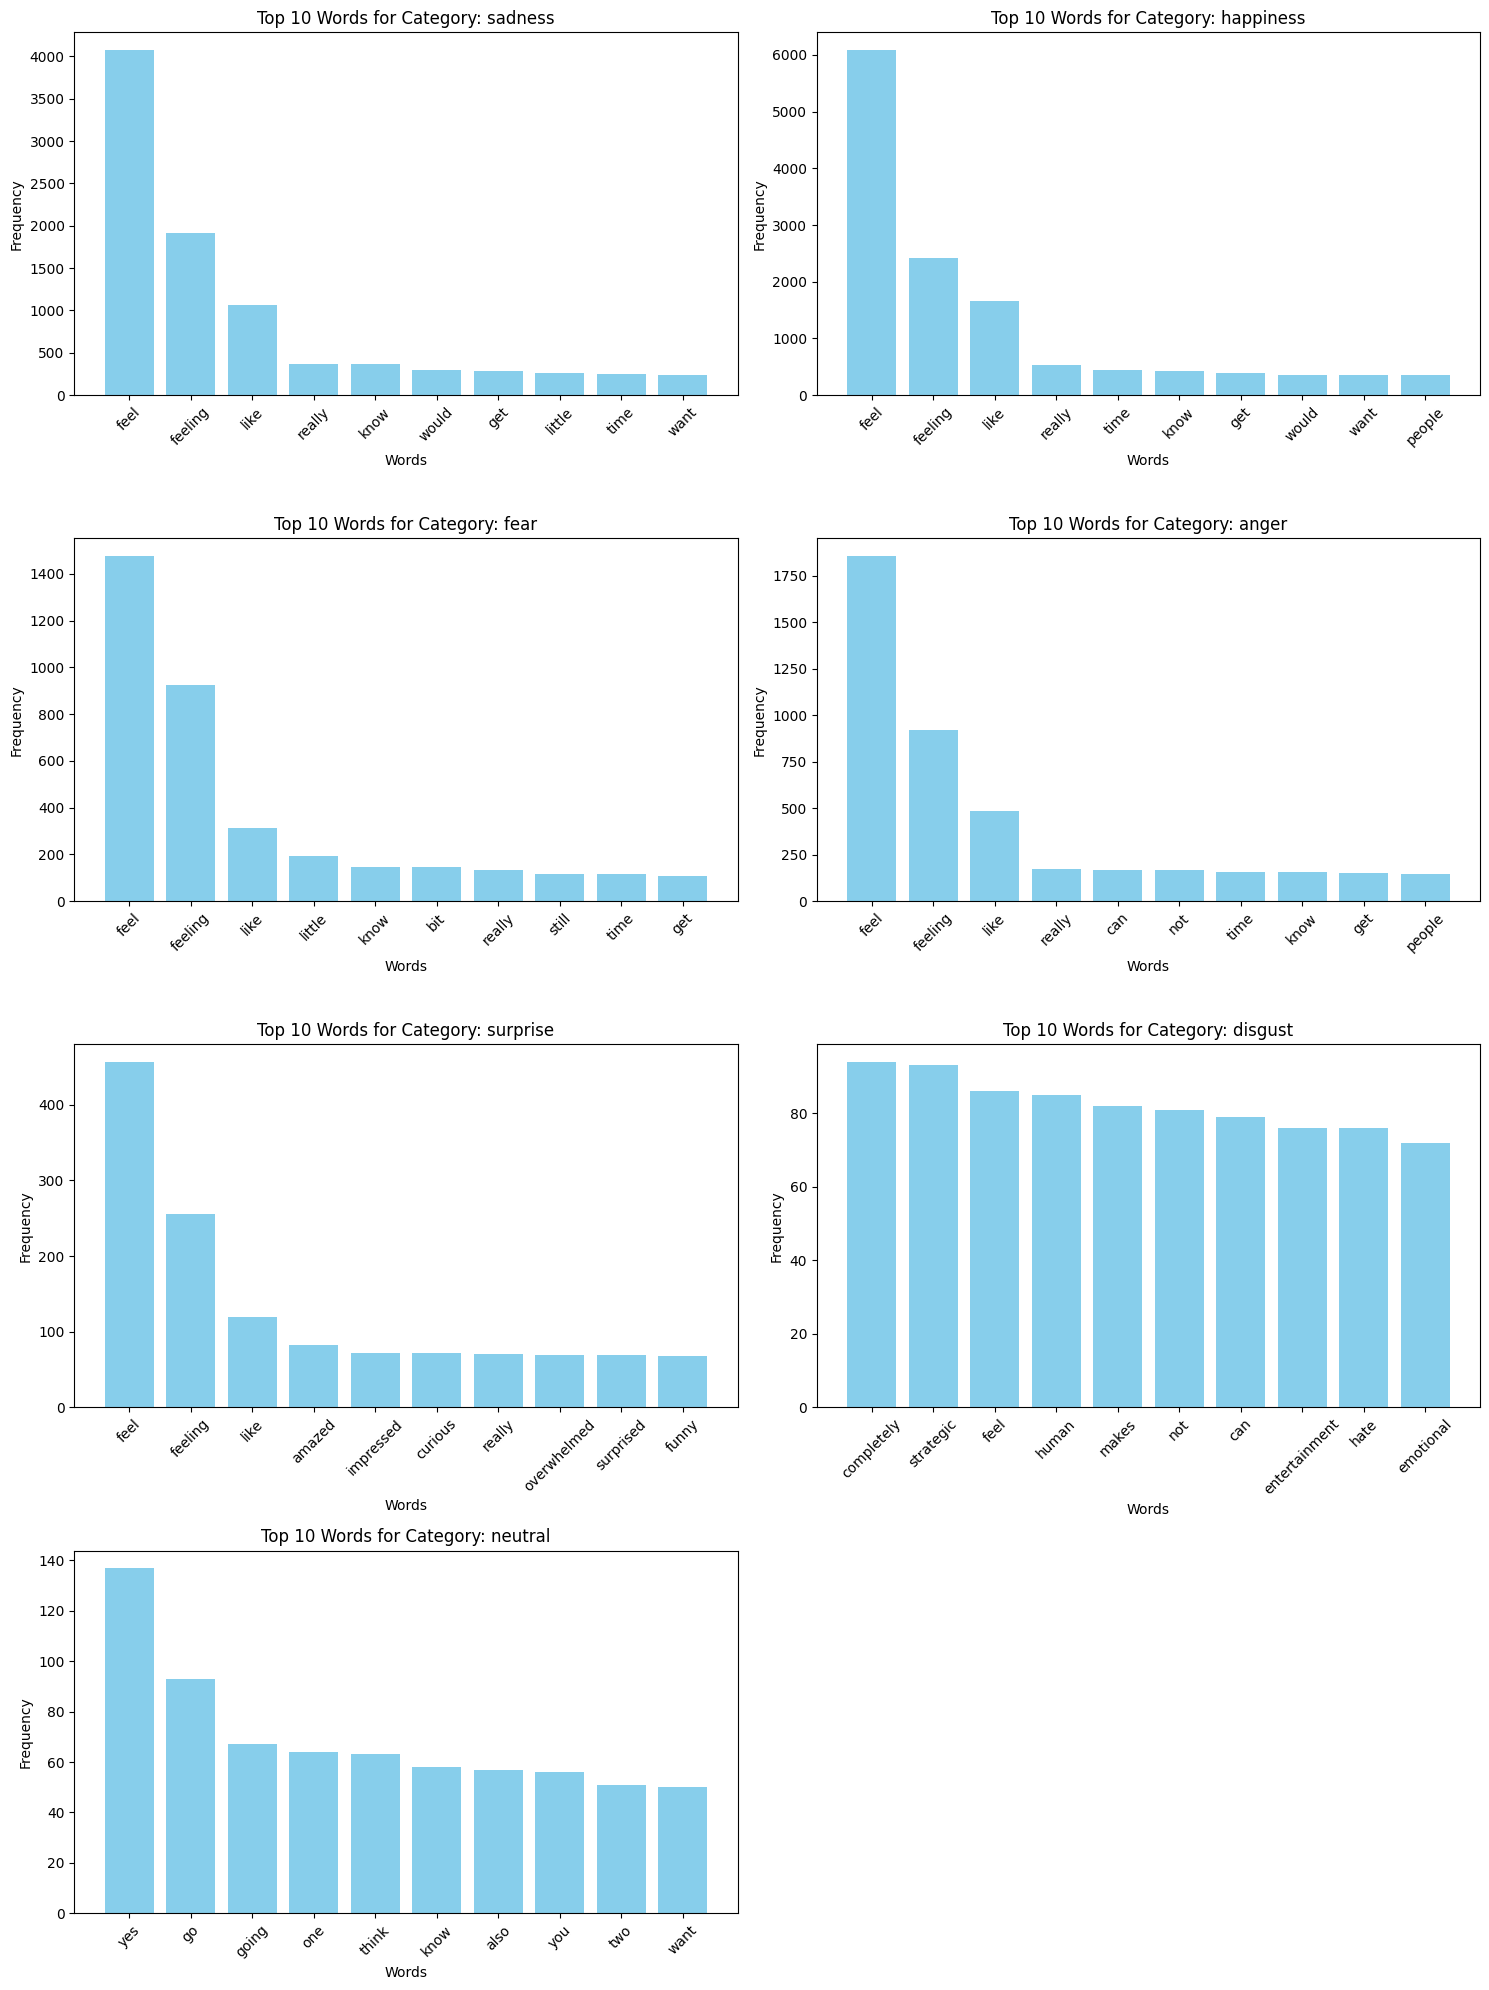


Most common words by category:

sadness:
  - feel: 4079
  - feeling: 1912
  - like: 1069
  - really: 370
  - know: 362
  - would: 296
  - get: 290
  - little: 259
  - time: 255
  - want: 240

happiness:
  - feel: 6094
  - feeling: 2423
  - like: 1658
  - really: 530
  - time: 445
  - know: 432
  - get: 388
  - would: 360
  - want: 357
  - people: 351

fear:
  - feel: 1478
  - feeling: 925
  - like: 315
  - little: 192
  - know: 147
  - bit: 146
  - really: 134
  - still: 116
  - time: 116
  - get: 108

anger:
  - feel: 1858
  - feeling: 918
  - like: 483
  - really: 172
  - can: 167
  - not: 166
  - time: 158
  - know: 155
  - get: 152
  - people: 148

surprise:
  - feel: 457
  - feeling: 256
  - like: 119
  - amazed: 83
  - impressed: 72
  - curious: 72
  - really: 70
  - overwhelmed: 69
  - surprised: 69
  - funny: 68

disgust:
  - completely: 94
  - strategic: 93
  - feel: 86
  - human: 85
  - makes: 82
  - not: 81
  - can: 79
  - entertainment: 76
  - hate: 76
  - emotional: 72

n

In [19]:
def plot_top_words_by_category(df, text_col="text_swapped_balanced", label_col="main_category", top_n=10):
    """Plot the top words for each category"""
    print(f"\n=== ANALYZING TOP {top_n} WORDS BY CATEGORY ===")

    stop_words = set(stopwords.words('english'))
    unique_categories = df[label_col].unique()
    num_categories = len(unique_categories)

    # Create a grid for plotting
    ncols = 2
    nrows = math.ceil(num_categories / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
    axes = axes.flatten()

    # Store word frequencies by category for display
    category_word_counts = {}

    for i, category in enumerate(unique_categories):
        # Filter texts for the current category
        category_texts = df[df[label_col] == category][text_col]
        # Combine all texts into one string
        combined_text = " ".join(category_texts.tolist())
        # Tokenize: convert to lowercase and extract words
        words = re.findall(r'\w+', combined_text.lower())  # Use combined_text.lower() to fix the error
        # Remove stopwords
        #filtered_words = [word for word in words if word not in stop_words]
        # Count word frequencies
        word_counts = Counter(words)
        # Get the top N most common words
        top_words = word_counts.most_common(top_n)

        # Store for display
        category_word_counts[category] = top_words

        # If there are words, unzip the results
        if top_words:
            words_plot, counts_plot = zip(*top_words)
        else:
            words_plot, counts_plot = ([], [])

        ax = axes[i]
        ax.bar(words_plot, counts_plot, color='skyblue')
        ax.set_title(f"Top {top_n} Words for Category: {category}")
        ax.set_xlabel("Words")
        ax.set_ylabel("Frequency")
        ax.tick_params(axis='x', rotation=45)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Print the word frequencies for each category
    print("\nMost common words by category:")
    for category, words in category_word_counts.items():
        print(f"\n{category}:")
        for word, count in words:
            print(f"  - {word}: {count}")

    return category_word_counts

# Execute and show results
word_counts = plot_top_words_by_category(df)

In [ ]:
# print the swapped text
df

,text,main_category,text_length_chars,text_length_words,text_swapped_balanced,emotion_intensity
0,feeling rather rotten ambitious right,sadness,37,5,feeling rather rotten ambitious right,0.5
1,updating blog feel shitty,sadness,25,4,updating blog feel shitty,0.5
2,never make separate ever want feel like ashamed,sadness,47,8,never make separate ever want feel like ashamed,0.5
3,left bouquet red yellow tulips arm feeling sli...,happiness,70,10,left bouquet red yellow tulips arm feeling sli...,0.5
4,feeling little vain one,sadness,23,4,feeling little vain one,0.5
...,...,...,...,...,...,...
24871,climb it.,neutral,9,2,climb it .,0.5
24872,"it, maneuver way.",neutral,17,3,"it , maneuver way .",0.5
24873,teammates ropes.,neutral,16,2,teammates ropes .,0.5
24874,determine pace.,neutral,15,2,determine pace .,0.5


In [ ]:
# rename df
df1 = df.copy()

In [ ]:
# drop colums
df.drop(columns=['text_length_chars', 'text','text_length_words'], inplace=True)

#Rename columns
df.rename(columns={'text_swapped_balanced': 'text'}, inplace=True)

In [ ]:
# download file
from google.colab import files
df.to_csv('augment_ai_df.csv', index=False)
files.download('augment_ai_df.csv')

In [ ]:
# Download the correct POS tagger
#nltk.download('averaged_perceptron_tagger')

# Download 'averaged_perceptron_tagger_eng' specifically
nltk.download('averaged_perceptron_tagger_eng')  # This line is added

# Manually set the path for NLTK data
import os
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if nltk_data_path not in nltk.data.path:
    nltk.data.path.append(nltk_data_path)

# Re-attempt augmentation
import nlpaug.augmenter.word as naw


# Define the augmenter using WordNet
syn_aug = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=2, aug_p=0.3)


def balance_dataset(df, text_col="text", label_col="main_category", augmenter=None):
    class_counts = df[label_col].value_counts()
    median_count = round(class_counts.median())

    balanced_data = []

    for lbl in class_counts.index:
        category_df = df[df[label_col] == lbl]
        needed_samples = median_count - len(category_df)

        if needed_samples <= 0:
            # If we already have enough samples, just take the first median_count
            balanced_data.append(category_df.sample(n=median_count, random_state=42))
        else:
            # Include all original samples
            balanced_data.append(category_df)

            # Only augment what we need
            samples_to_augment = category_df.sample(
                n=min(needed_samples, len(category_df)),
                replace=(needed_samples > len(category_df)),
                random_state=42
            )

            # Apply augmentation and track similarity
            augmented_samples = []
            used_texts = set(category_df[text_col].tolist())

            for _, row in samples_to_augment.iterrows():
                attempts = 0
                # augmented_text is now a string instead of a list
                augmented_text = augmenter.augment(row[text_col], n=1)[0]

                # Try up to 3 times to get a sufficiently different sample
                while augmented_text in used_texts and attempts < 3:
                    augmented_text = augmenter.augment(row[text_col], n=1)[0]
                    attempts += 1

                augmented_row = row.copy()
                augmented_row[text_col] = augmented_text
                augmented_samples.append(augmented_row)
                used_texts.add(augmented_text)

            # If we still need more samples, use replace=True
            if len(augmented_samples) < needed_samples:
                more_samples = category_df.sample(
                    n=needed_samples - len(augmented_samples),
                    replace=True,
                    random_state=43  # Different seed
                )
                for _, row in more_samples.iterrows():
                    augmented_row = row.copy()
                    augmented_row[text_col] = augmenter.augment(row[text_col], n=1)[0]
                    augmented_samples.append(augmented_row)

            # Add the augmented samples
            if augmented_samples:
                balanced_data.append(pd.DataFrame(augmented_samples))

    return pd.concat(balanced_data).reset_index(drop=True)

# Apply augmentation
balanced_df = balance_dataset(df, "text", "main_category", augmenter=syn_aug)

# Verify the new class distribution
print("Original Class Distribution:\n", df["main_category"].value_counts())
print("Balanced Class Distribution:\n", balanced_df["main_category"].value_counts())

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Original Class Distribution:
 main_category
happiness    8930
sadness      5983
anger        3386
fear         2525
neutral      1950
disgust      1125
surprise      975
Name: count, dtype: int64
Balanced Class Distribution:
 main_category
happiness    2525
sadness      2525
anger        2525
fear         2525
neutral      2525
disgust      2525
surprise     2525
Name: count, dtype: int64


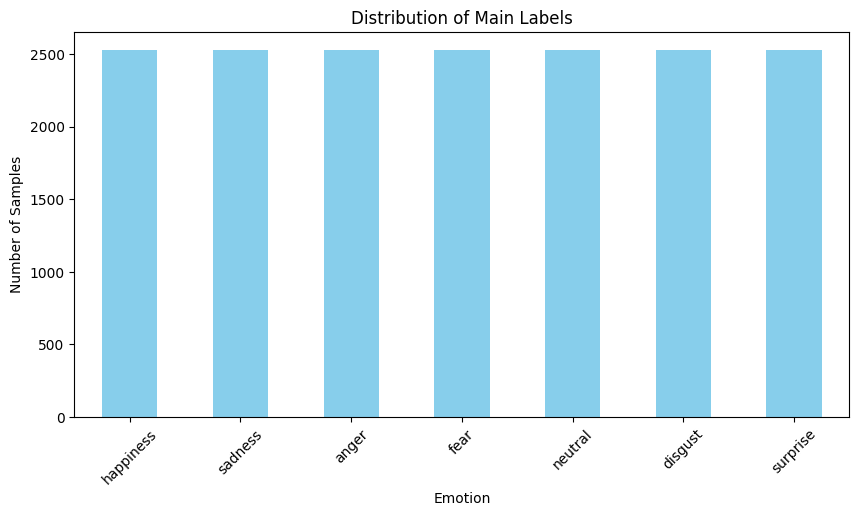

In [26]:
label_counts = balanced_df['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [27]:
# drop duplicates
balanced_df.drop_duplicates(subset=['text'], inplace=True)

# Reset index
balanced_df.reset_index(drop=True, inplace=True)

# Verify new distribution
print("Original Class Distribution:\n", df["main_category"].value_counts())
print("Balanced Class Distribution (After Dropping Duplicates):\n", balanced_df["main_category"].value_counts())

Original Class Distribution:
 main_category
happiness    8930
sadness      5983
anger        3386
fear         2525
neutral      1950
disgust      1125
surprise      975
Name: count, dtype: int64
Balanced Class Distribution (After Dropping Duplicates):
 main_category
happiness    2520
sadness      2511
fear         2505
neutral      2496
anger        2492
disgust      2490
surprise     2452
Name: count, dtype: int64


In [ ]:
# print df 
df

,main_category,text,emotion_intensity
0,sadness,feeling rather rotten ambitious right,0.5
1,sadness,updating blog feel shitty,0.5
2,sadness,never make separate ever want feel like ashamed,0.5
3,happiness,left bouquet red yellow tulips arm feeling sli...,0.5
4,sadness,feeling little vain one,0.5
...,...,...,...
24871,neutral,climb it .,0.5
24872,neutral,"it , maneuver way .",0.5
24873,neutral,teammates ropes .,0.5
24874,neutral,determine pace .,0.5


In [ ]:
# download file
from google.colab import files
df.to_csv('augment_ai_df2.csv', index=False)
files.download('augment_ai_df2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>